# Maestría en Ciencia de Datos
### Autor: MSc. Jose Cardenas
### Tema: Regresión Logística Penalizada - Clasificación

## 1.Librerías a utilizar

In [34]:
import pandas as pd 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.metrics import (precision_score, recall_score,f1_score,accuracy_score)
warnings.filterwarnings("ignore")

#### Conectar con Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Funciones

In [3]:
def missing_tabla(df):
    miss_value = df.isnull().sum()
    miss_value_percent = 100*df.isnull().sum()/len(df)
    
    # Resultados
    resultado = pd.concat([miss_value,miss_value_percent], axis=1)
    resultado.rename(columns={0:'Cantidad de Missing',1:'% Porcentaje de Missing'}, inplace = True)
    resultado.sort_values(by='% Porcentaje de Missing', inplace = True, ascending = False)
    print('Cantidad de Missing por variable: ')
    return resultado

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    return(corr_mat)

def lambda_optimo_academico(modelo):
    score_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
    score_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)


    # Se identifica el óptimo y el óptimo + 1std
    min_score     = np.min(score_cv)
    sd_min_score  = score_sd[np.argmin(score_cv)]
    min_score_1sd = np.max(score_cv[score_cv <= min_score + sd_min_score])
    optimo       = modelo.alphas[np.argmin(score_cv)]
    optimo_1sd   = modelo.alphas[score_cv == min_score_1sd]

    try:
      pass
      # graficar_lambda_optimo_academico(score_cv,score_sd,optimo_1sd,optimo)
    except:
      print("Error al grááficar el lambda académico y de negocio")

    return optimo_1sd, optimo

def graficar_lambda_optimo_academico(score_cv,score_sd,optimo_1sd,optimo):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(cv_ridge.alphas, score_cv)
    ax.fill_between(
        modelo.alphas,
        score_cv + score_sd,
        score_cv - score_sd,
        alpha=0.2
    )

    ax.axvline(
        x         = optimo,
        c         = "gray",
        linestyle = '--',
        label     = 'óptimo'
    )

    ax.axvline(
        x         = optimo_1sd,
        c         = "blue",
        linestyle = '--',
        label     = 'óptimo_1sd'
    )
    ax.set_xscale('log')
    ax.set_ylim([0,None])
    ax.set_title('Evolución del error CV en función de la regularización')
    ax.set_xlabel('alpha')
    ax.set_ylabel('RMSE')
    plt.legend();

# Calcula los indicadores
def calcula_indicadores(y, y_hat):

    accuracy = accuracy_score(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)

    return pd.DataFrame([accuracy, precision, recall, f1],index=['Accuracy','Precision', 'Recall', 'F1'],columns=['Indicador'])

def lasso_cv(x_, y_, alphas_, metrica_='GINI'):
    metrics = []
    for alpha in alphas_:
      lasso = Lasso(alpha=alpha).fit(x_, y_) 
      pred_lasso = lasso.predict(x_)
      resultado_lasso = calcula_indicadores(y_,pred_lasso)
      metrics.append(resultado_lasso.loc[metrica_].values[0])
      
    return metrics

def ridge_cv(x_, y_, alphas_, metrica_='GINI'):
    metrics = []
    for alpha in alphas_:
      ridge = RidgeClassifier(alpha=alpha).fit(x_, y_) 
      pred_ridge = ridge.predict(x_)
      resultado_ridge = calcula_indicadores(y_,pred_ridge)
      metrics.append(resultado_ridge.loc[metrica_].values[0])
      
    return metrics

## 2. Data a Utilizar

In [5]:
ruta = "/content/drive/MyDrive/Cursos/Cursos Tercer Ciclo/Aprendizaje Maquina/Sesión 4/Regresion penalizada/Clasificacion/Datas/"
nombre_archivo = "PimaIndiansDiabetes.csv"
data_original = pd.read_csv(ruta + nombre_archivo)

## 3.Tratamiento De La Data

#### Análisis descriptivo de la data

In [6]:
data_original.head(10)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,1,89,66,23,94,28.1,0.167,21,neg
1,0,137,40,35,168,43.1,2.288,33,pos
2,3,78,50,32,88,31.0,0.248,26,pos
3,2,197,70,45,543,30.5,0.158,53,pos
4,1,189,60,23,846,30.1,0.398,59,pos
5,5,166,72,19,175,25.8,0.587,51,pos
6,0,118,84,47,230,45.8,0.551,31,pos
7,1,103,30,38,83,43.3,0.183,33,neg
8,1,115,70,30,96,34.6,0.529,32,pos
9,3,126,88,41,235,39.3,0.704,27,neg


In [7]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  392 non-null    int64  
 1   glucose   392 non-null    int64  
 2   pressure  392 non-null    int64  
 3   triceps   392 non-null    int64  
 4   insulin   392 non-null    int64  
 5   mass      392 non-null    float64
 6   pedigree  392 non-null    float64
 7   age       392 non-null    int64  
 8   diabetes  392 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 27.7+ KB


In [8]:
resumen = data_original.describe().transpose()
resumen.to_csv(ruta + "tabla_resumen.csv")
resumen

,count,mean,std,min,25%,50%,75%,max
pregnant,392.0,3.301020,3.211424,0.000,1.00000,2.0000,5.000,17.00
glucose,392.0,122.627551,30.860781,56.000,99.00000,119.0000,143.000,198.00
pressure,392.0,70.663265,12.496092,24.000,62.00000,70.0000,78.000,110.00
triceps,392.0,29.145408,10.516424,7.000,21.00000,29.0000,37.000,63.00
insulin,392.0,156.056122,118.841690,14.000,76.75000,125.5000,190.000,846.00
mass,392.0,33.086224,7.027659,18.200,28.40000,33.2000,37.100,67.10
pedigree,392.0,0.523046,0.345488,0.085,0.26975,0.4495,0.687,2.42
age,392.0,30.864796,10.200777,21.000,23.00000,27.0000,36.000,81.00


In [9]:
# Conteo de nulos
missing_tabla(data_original)

Cantidad de Missing por variable: 


,Cantidad de Missing,% Porcentaje de Missing
pregnant,0,0.0
glucose,0,0.0
pressure,0,0.0
triceps,0,0.0
insulin,0,0.0
mass,0,0.0
pedigree,0,0.0
age,0,0.0
diabetes,0,0.0


## 4. Variables del Modelo

In [11]:
data = data_original.copy()
data['diabetes'] = np.where(data['diabetes']=='pos',1,0)
x = data[data.columns.drop('diabetes')]
y = data['diabetes']

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  392 non-null    int64  
 1   glucose   392 non-null    int64  
 2   pressure  392 non-null    int64  
 3   triceps   392 non-null    int64  
 4   insulin   392 non-null    int64  
 5   mass      392 non-null    float64
 6   pedigree  392 non-null    float64
 7   age       392 non-null    int64  
 8   diabetes  392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 27.7 KB


In [13]:
print("Clase 0:",data[data['diabetes']==0]['diabetes'].count()/data.shape[0])
print("Clase 1:",data[data['diabetes']==1]['diabetes'].count()/data.shape[0])

Clase 0: 0.6683673469387755
Clase 1: 0.33163265306122447


## 5. Correlación

In [14]:
# Spearman
matriz_correlacion, matriz_p_valor = spearmanr(data)
df_correlacion = pd.DataFrame(matriz_correlacion, columns=data.columns, index=data.columns)
df_correlacion

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
pregnant,1.000000,0.190481,0.152414,0.054759,0.123154,-0.065551,0.011713,0.633657,0.200234
glucose,0.190481,1.000000,0.236609,0.215838,0.658958,0.199071,0.089346,0.350305,0.498729
pressure,0.152414,0.236609,1.000000,0.250106,0.131639,0.317427,-0.020892,0.329244,0.198127
triceps,0.054759,0.215838,0.250106,1.000000,0.241145,0.674393,0.093049,0.241507,0.260153
insulin,0.123154,0.658958,0.131639,0.241145,1.000000,0.300906,0.131515,0.260747,0.375019
mass,-0.065551,0.199071,0.317427,0.674393,0.300906,1.000000,0.096242,0.166963,0.267077
pedigree,0.011713,0.089346,-0.020892,0.093049,0.131515,0.096242,1.000000,0.102984,0.198214
age,0.633657,0.350305,0.329244,0.241507,0.260747,0.166963,0.102984,1.000000,0.397355
diabetes,0.200234,0.498729,0.198127,0.260153,0.375019,0.267077,0.198214,0.397355,1.000000


In [15]:
df_correlacion = tidy_corr_matrix(df_correlacion)
df_correlacion['filtro'] = np.where(df_correlacion['abs_r'] > 0.6, 1, 0)

df_correlacion.to_csv(ruta + "correlacion_variables.csv", index=False)
df_correlacion

,variable_1,variable_2,r,abs_r,filtro
48,mass,triceps,0.674393,0.674393,1
32,triceps,mass,0.674393,0.674393,1
37,insulin,glucose,0.658958,0.658958,1
13,glucose,insulin,0.658958,0.658958,1
63,age,pregnant,0.633657,0.633657,1
...,...,...,...,...,...
3,pregnant,triceps,0.054759,0.054759,0
24,pressure,pedigree,-0.020892,0.020892,0
56,pedigree,pressure,-0.020892,0.020892,0
6,pregnant,pedigree,0.011713,0.011713,0


## 6. Modelado

#### Primer Modelo Ridge

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=1234)

alphas = np.logspace(-3, 5, 500)

In [19]:
# Modelo Base

modelo = RidgeClassifierCV(
            alphas          = alphas,
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )
_ = modelo.fit(X = X_train, y = y_train)

In [20]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
metric_cv = modelo.cv_values_.reshape((-1, 500)).mean(axis=0)
metric_sd = modelo.cv_values_.reshape((-1, 500)).std(axis=0)

# Se identifica el óptimo y el óptimo + 1std
min_metric     = np.min(metric_cv)
sd_min_metric  = metric_sd[np.argmin(metric_cv)]
min_metric_1sd = np.max(metric_cv[metric_cv <= min_metric + sd_min_metric])
optimo       = modelo.alphas[np.argmin(metric_cv)]
optimo_1sd   = modelo.alphas[metric_cv == min_metric_1sd][0]

print("Lambda Negocio:",optimo)
print("Lambda Optimo:",optimo_1sd)

Lambda Negocio: 0.16922203516410372
Lambda Optimo: 100000.0


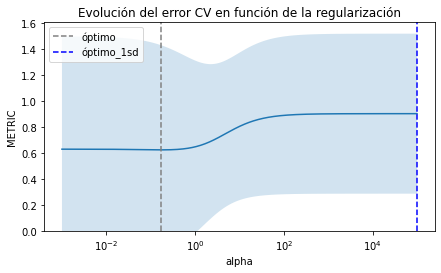

In [21]:
# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, metric_cv)
ax.fill_between(
    modelo.alphas,
    metric_cv + metric_sd,
    metric_cv - metric_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('METRIC')
plt.legend();

In [22]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.16922203516410372


In [23]:
ridge_best_1 = RidgeClassifier(alpha=optimo).fit(X_train,y_train)
pred_ridge_1 = ridge_best_1.predict(X_test)

In [24]:
ridge_best_2 = RidgeClassifier(alpha=optimo_1sd).fit(X_train,y_train)
pred_ridge_2 = ridge_best_2.predict(X_test)

In [25]:
# Indicadores de validación
resultado_ridge_1 = calcula_indicadores(y_test,pred_ridge_1)
resultado_ridge_1

,Indicador
Accuracy,0.797468
Precision,0.722222
Recall,0.541667
F1,0.619048


In [26]:
# Indicadores de validación
resultado_ridge_2 = calcula_indicadores(y_test,pred_ridge_2)
resultado_ridge_2

,Indicador
Accuracy,0.810127
Precision,0.764706
Recall,0.541667
F1,0.634146


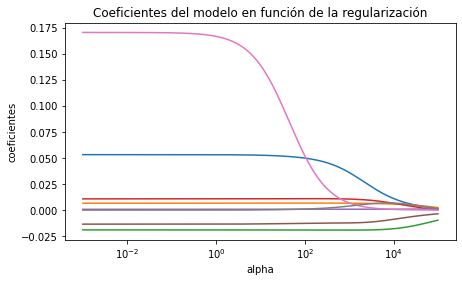

In [27]:
coefs = []

for alpha in alphas:
    modelo_temp = RidgeClassifier(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(x, y)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

In [74]:
# Coeficientes Ridge
print('========= Coeficientes del Modelo Ridge 1 =========')
#Coeficientes del Modelo 
coef_ridge_1 = pd.DataFrame(ridge_best_1.coef_,columns=x.columns,index=['Coeficiente']).transpose()
coef_ridge_1

========= Coeficientes del Modelo Ridge 1 =========


,Coeficiente
pregnant,0.038751
glucose,0.012405
pressure,0.000724
triceps,0.001878
insulin,-0.000112
mass,0.016893
pedigree,0.397940
age,0.008484


In [73]:
# Coeficientes Ridge
print('========= Coeficientes del Modelo Ridge 2 =========')
#Coeficientes del Modelo 
coef_ridge_2 = pd.DataFrame(ridge_best_2.coef_,columns=x.columns,index=['Coeficiente']).transpose()
coef_ridge_2

========= Coeficientes del Modelo Ridge 2 =========


,Coeficiente
pregnant,0.001532
glucose,0.009625
pressure,0.002324
triceps,0.002971
insulin,0.000776
mass,0.002402
pedigree,0.000177
age,0.004654


#### Segundo Modelo Lasso

In [38]:
data = data_original.copy()
data['diabetes'] = np.where(data['diabetes']=='pos',1,0)
x = data[data.columns.drop('diabetes')]
y = data['diabetes']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=1234)

alphas = np.linspace(0, 100, 1000)

In [82]:
metrics = []
metrica_= "Accuracy"
for c_alpha in alphas:
  lasso = LogisticRegression(penalty='l1',solver='saga', C=c_alpha).fit(X_train, y_train)
  pred_lasso = lasso.predict(X_test)
  resultado_lasso = calcula_indicadores(y_test,pred_lasso)
  metrics.append(resultado_lasso.loc[metrica_].values[0])

In [83]:
resultado = pd.DataFrame([alphas,metrics]).transpose()
resultado.columns = ["C", "metric"]
resultado

,C,metric
0,0.0000,0.696203
1,0.1001,0.721519
2,0.2002,0.721519
3,0.3003,0.734177
4,0.4004,0.734177
...,...,...
995,99.5996,0.734177
996,99.6997,0.734177
997,99.7998,0.734177
998,99.8999,0.734177


In [84]:
resultado[resultado['metric']==resultado['metric'].max()]

,C,metric
3,0.300300,0.734177
4,0.400400,0.734177
5,0.500501,0.734177
6,0.600601,0.734177
7,0.700701,0.734177
...,...,...
995,99.599600,0.734177
996,99.699700,0.734177
997,99.799800,0.734177
998,99.899900,0.734177


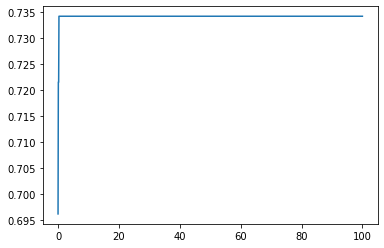

In [85]:
plt.plot(alphas,metrics)

In [86]:
c_best = 0.303030
lasso_best = LogisticRegression(penalty='l1',solver='saga', C=c_best).fit(X_train, y_train)
pred_lasso = lasso_best.predict(X_test)
resultado_lasso = calcula_indicadores(y_test,pred_lasso)

In [87]:
resultado_lasso

,Indicador
Accuracy,0.734177
Precision,0.578947
Recall,0.458333
F1,0.511628


In [88]:
# Coeficientes Lasso
print('========= Coeficientes del Lasso =========')
#Coeficientes del Modelo 
coef_lasso = pd.DataFrame(lasso_best.coef_,columns=x.columns,index=['Coeficiente']).transpose()
coef_lasso

========= Coeficientes del Lasso =========


,Coeficiente
pregnant,0.017799
glucose,0.015092
pressure,-0.046584
triceps,0.010593
insulin,0.001884
mass,-0.013781
pedigree,0.000588
age,0.020464


## 7. Comparación de Indicadores

In [65]:
# Indicadores
indicadores = pd.concat(
    [resultado_ridge_1,resultado_ridge_2,resultado_lasso],
    axis=1)
indicadores.columns = ["Ridge_1","Ridge_2","Lasso"]
indicadores

,Ridge_1,Ridge_2,Lasso
Accuracy,0.797468,0.810127,0.734177
Precision,0.722222,0.764706,0.578947
Recall,0.541667,0.541667,0.458333
F1,0.619048,0.634146,0.511628


In [75]:
# Coeficientes
coef_ridge_1
coeficientes = pd.concat(
    [coef_ridge_1,coef_ridge_2,coef_lasso],
    axis=1)
indicadores.columns = ["Ridge_1","Ridge_2","Lasso"]
coeficientes

,Coeficiente,Coeficiente,Coeficiente
pregnant,0.038751,0.001532,0.017674
glucose,0.012405,0.009625,0.015100
pressure,0.000724,0.002324,-0.046600
triceps,0.001878,0.002971,0.010664
insulin,-0.000112,0.000776,0.001884
mass,0.016893,0.002402,-0.013803
pedigree,0.397940,0.000177,0.000603
age,0.008484,0.004654,0.020460


### Tercer Modelo Elasticnet

#### Tarea